# Tutorial 7: ICE and PDP Interpretation Tutorial

<img src="../../docs/imgs/lightautoml_logo_color.png" alt="LightAutoML logo" style="width:100%;"/>

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML)

Partial dependence plot (PDP) and Individual Conditional Expectation (ICE) are two model-agnostic interpretation methods (see details [here](https://compstat-lmu.github.io/iml_methods_limitations/pdp.html)).

## Download library and make some imports

In [1]:
# !pip install lightautoml

In [2]:
# Standard python libraries
import os
import requests

# Installed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split


# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [3]:
plt.rcParams.update({'font.size': 20})
sns.set(rc={'figure.figsize':(15, 11)})
sns.set(style="whitegrid", font_scale=1.5)

N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 120 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name

## Prepare data

Load a dataset from the repository if doesn't clone repository by git.

In [4]:
DATASET_DIR = './data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

In [5]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)
        
data = pd.read_csv(DATASET_FULLNAME)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

CPU times: user 223 ms, sys: 52.9 ms, total: 276 ms
Wall time: 503 ms


In [6]:
train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)

## Create AutoML from preset

Also works with ``lightautoml.automl.presets.tabular_presets.TabularUtilizedAutoML``.

In [7]:
%%time 

task = Task('binary', )
roles = {'target': TARGET_NAME,}

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1, log_file = 'train.log')

[16:58:33] Stdout logging level is INFO.
[16:58:33] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[16:58:33] Task: binary

[16:58:33] Start automl preset with listed constraints:
[16:58:33] - time: 120.00 seconds
[16:58:33] - CPU: 8 cores
[16:58:33] - memory: 16 GB

[16:58:33] Train data shape: (8000, 123)

[16:58:36] Layer 1 train process start. Time left 117.58 secs
[16:58:36] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:58:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7340989893230383
[16:58:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:58:40] Time left 112.94 secs

[16:58:43] Selector_LightGBM fitting and predicting completed
[16:58:44] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:58:53] Time limit exceeded after calculating fold 3

[16:58:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7336652733096534
[16:58:53] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting complet

## Calculate interpretation data

ICE shows the functional relationship between the predicted response and the feature separately for each instance. PDP averages the individual lines of an ICE plot.

### Numeric features

For numeric features you can specify ``n_bins`` - number of bins into which the range of feature values is divided.

#### Calculate data for PDP plot manually:

In [8]:
%%time

grid, ys, counts = automl.get_individual_pdp(test_data, feature_name='DAYS_BIRTH', n_bins=30)

100%|██████████| 30/30 [00:18<00:00,  1.63it/s]

CPU times: user 2min 2s, sys: 7.35 s, total: 2min 9s
Wall time: 18.4 s


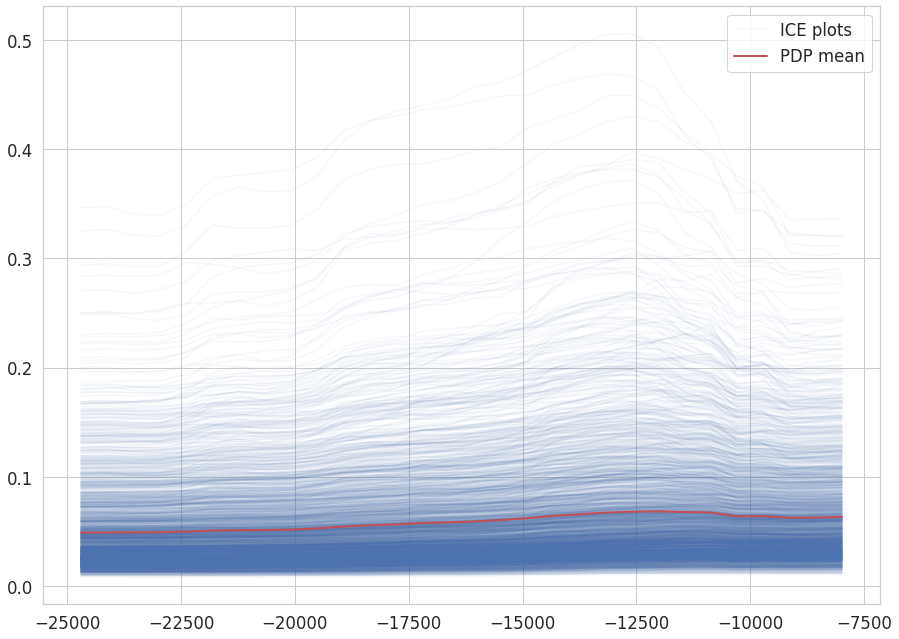

CPU times: user 5.9 s, sys: 3.63 s, total: 9.53 s
Wall time: 2.46 s


In [9]:
%%time

X = np.array([item.ravel() for item in ys]).T

plt.figure(figsize=(15, 11))
plt.plot(grid, X[0], alpha=0.05, color='m', label='ICE plots')
for i in range(1, X.shape[0]):
    plt.plot(grid, X[i], alpha=0.05, color='b')
plt.plot(grid, X.mean(axis=0), linewidth=2, color='r', label='PDP mean')
plt.legend()
plt.show()

#### Built-in function:

100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


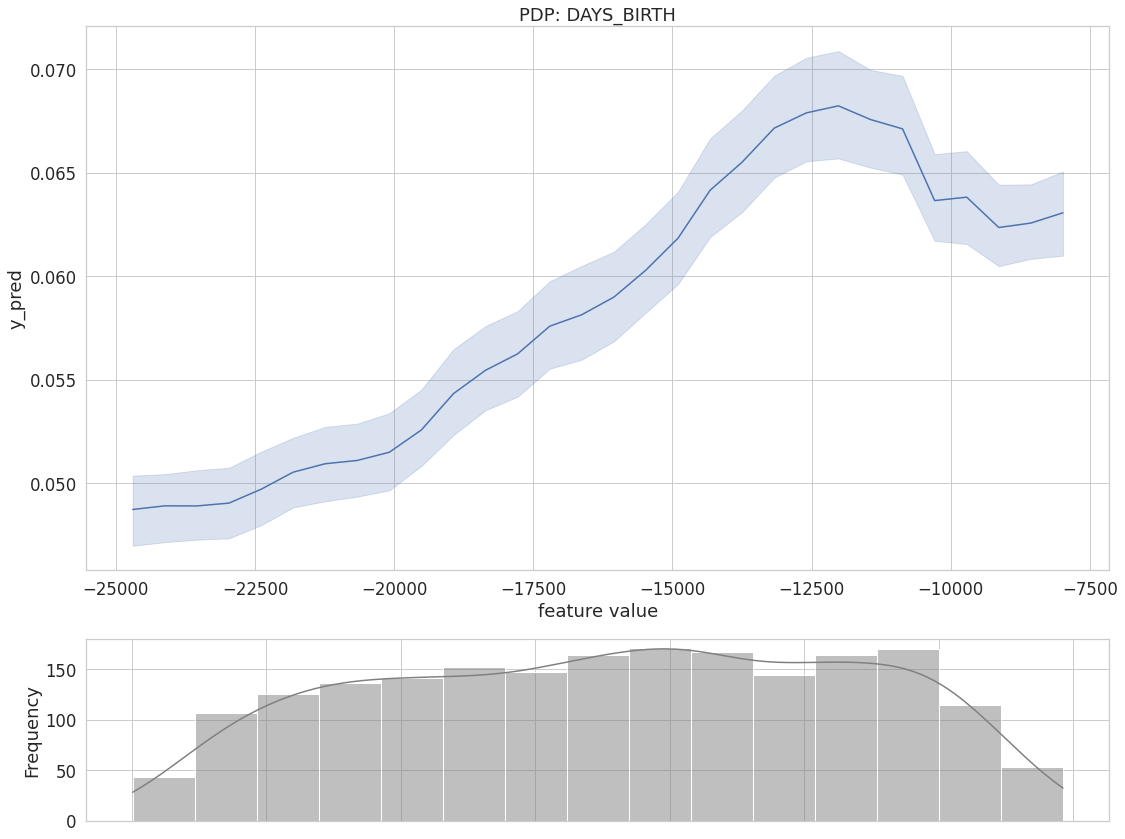

In [10]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH')

100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


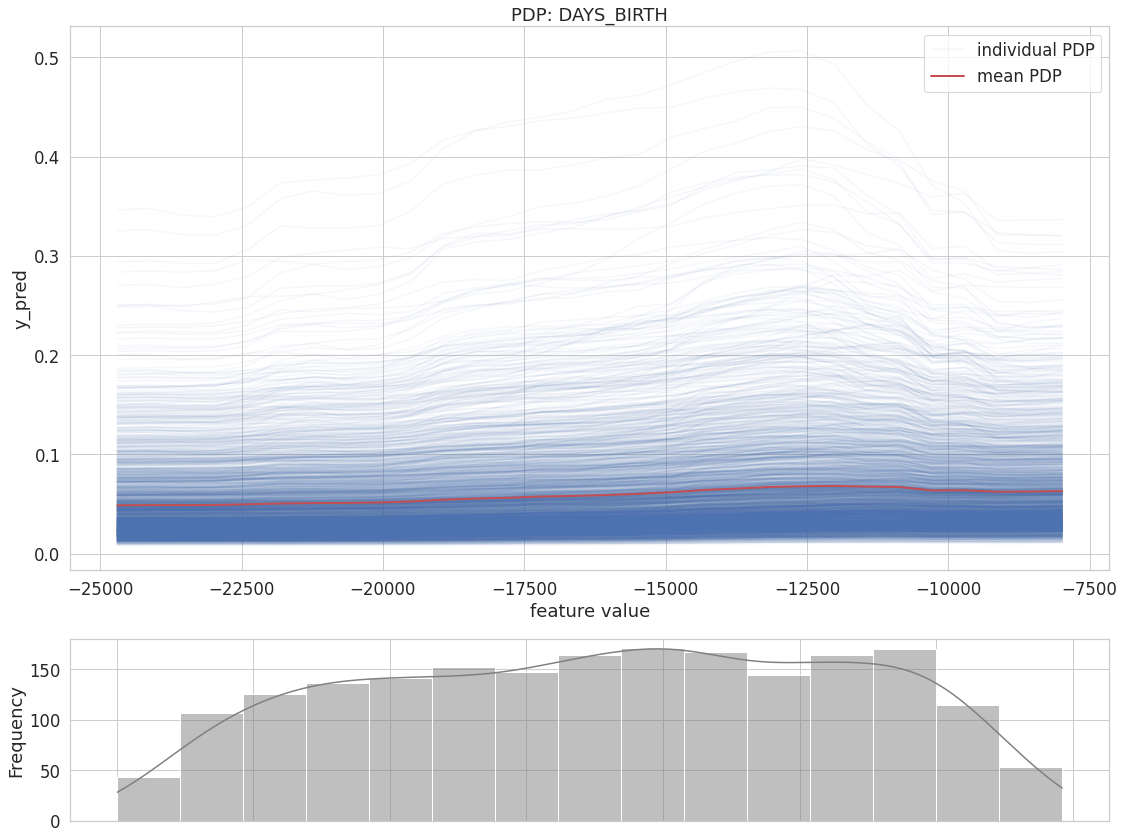

In [11]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH', individual=True)

### Categorical features

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


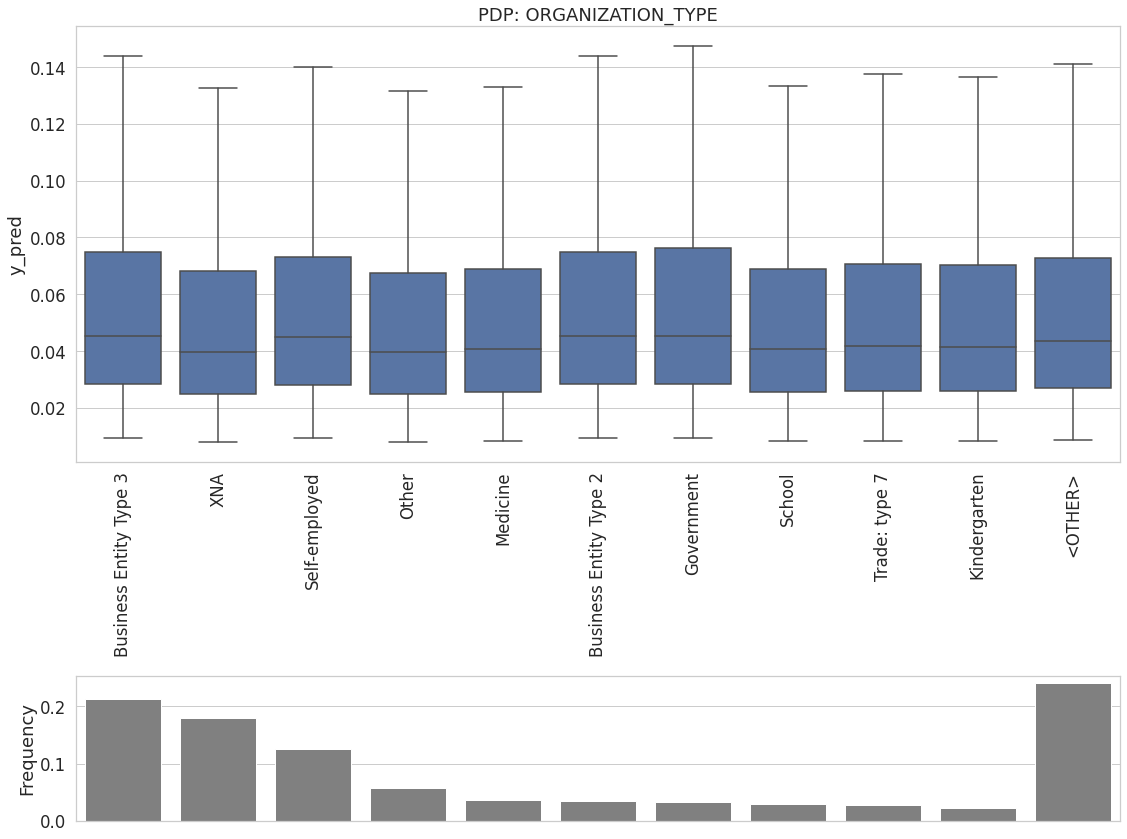

CPU times: user 43.8 s, sys: 2.54 s, total: 46.4 s
Wall time: 6.87 s


In [12]:
%%time

automl.plot_pdp(test_data, feature_name='ORGANIZATION_TYPE')

### Datetime features

For datetime features you can specify groupby level, allowed values: ``year``, ``month``, ``dayofweek``.

100%|██████████| 45/45 [00:27<00:00,  1.63it/s]


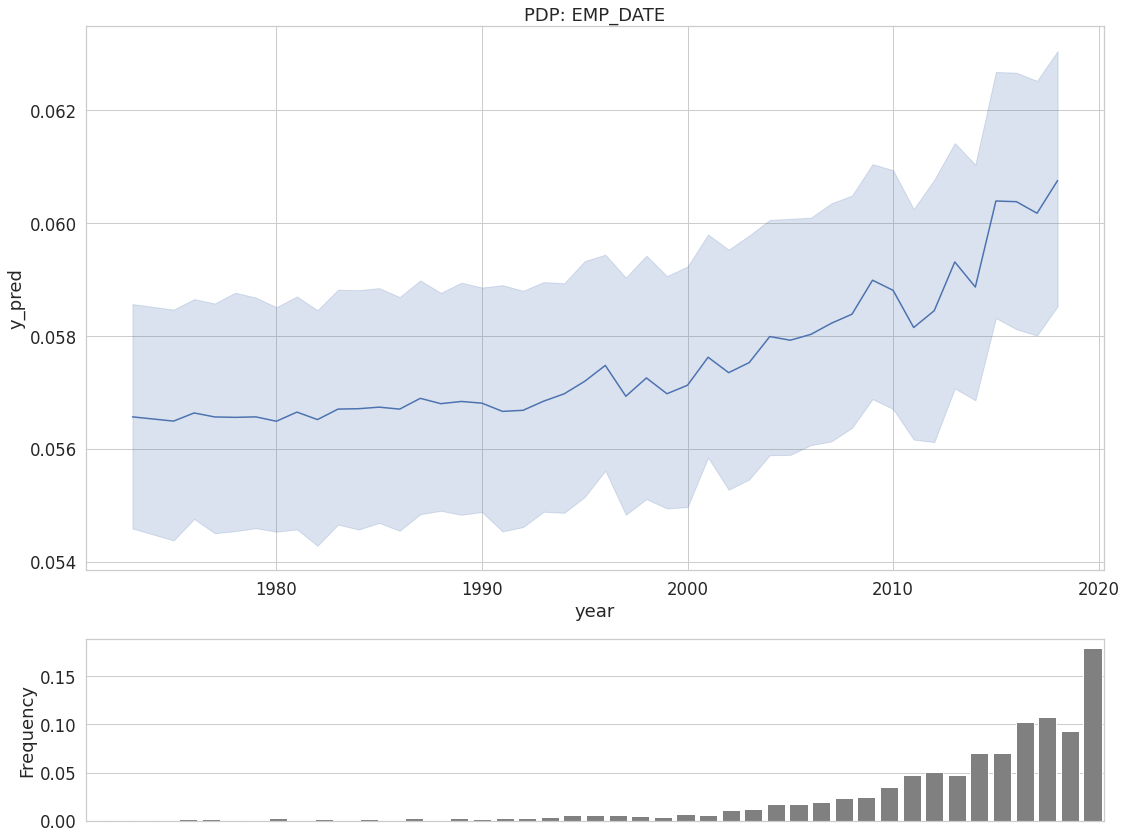

CPU times: user 3min 2s, sys: 10.2 s, total: 3min 12s
Wall time: 29.4 s


In [13]:
%%time

automl.plot_pdp(test_data, feature_name='EMP_DATE', datetime_level='year')